# Neural Transfer Style on Dataset with five classes

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import random as rn
from os.path import join, getsize
from tensorflow.keras import layers
from tensorflow.keras import models
from keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelBinarizer
from sklearn import metrics
import matplotlib.pyplot as plt
import matplotlib.style as style
import IPython.display as display
import matplotlib as mpl
import time
import functools

from PIL import Image
from tqdm import tqdm

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession


config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config = config)


mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

In [2]:
BATCH_SIZE = 64
CHANNELS = 3
IMG_HEIGHT = 250
IMG_WIDTH = 250
IMG_SIZE=(IMG_HEIGHT, IMG_WIDTH)
INPUT_SHAPE=IMG_SIZE + (3,)  # --> (224,224,3)

In [ ]:
style_weight=1e-2
content_weight=1e4
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

Utility functions for plot, extract images

In [3]:
def reset_random_seed():
  """ Set the random seed.
   
  """
  # The below is necessary for reproducible results of certain Python hash-based operations.
  os.environ["PYTHONHASHSEED"]=str(2)

  # The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
  np.random.seed(2)

  # The below is necessary for starting core Python generated random numbers in a well-defined state.
  rn.seed(2)

  # The below tf.random.set_seed will make random number generation in TensorFlow have a well-defined initial state.
  tf.random.set_seed(2)
  

def get_dataset(path, img_size = IMG_SIZE, batch_size = BATCH_SIZE, shuffle = True):
    """ Get the dataset given the directory name.
    Args:
    - apth (str): a string representing the name of the directory from which the dataset is retrieved.
    
    Returns:
    - ds (PrefetchDataset): a Dataset containing the elements in the directory.
  """
    return tf.keras.preprocessing.image_dataset_from_directory(
        path,
        seed = 2,
        image_size = img_size,
        batch_size = batch_size,
        shuffle = shuffle
    )



import math

def plot_images(list_images, list_labels, index_images):
  """ Plot the images with its label.
   
  """
  n = len(index_images)
  rows = math.ceil(n/4) 
  print(rows)
  columns = 4 
  fig = plt.figure(figsize=(columns*3,rows*3))
  for i, index in enumerate(index_images):
    fig.add_subplot(rows, columns, i + 1)
    
    img = np.squeeze(list_images[index].numpy().astype("uint8"))
    
    title = "Image " + str(index) + ", class: "+str('Negative' if list_labels[i] == 0 else 'Positive')
    
    plt.title(title)
    plt.imshow(img)
    
  fig.tight_layout()
  plt.show()


def plot_images_from_ds(list_images, list_labels, index_images):
  """ Plot the images with its label directly from the dataset.
   
  """
  class_name = ['amusement', 'awe', 'contentment', 'fear', 'sadness']
  n = len(index_images)
  rows = math.ceil(n/4) # per eccesso
  print(rows)
  columns = 4 
  
  fig = plt.figure(figsize=(columns*5,rows*5))
  for i, image_batch in enumerate(list_images):
    
    for j, index in enumerate(index_images):
      if i == int(index/BATCH_SIZE):
        index_batch = index%BATCH_SIZE
        img = image_batch[0][index_batch]
        
        fig.add_subplot(rows, columns, j + 1)
        
        img = np.squeeze(img.numpy().astype("uint8"))
        title = "Image " + str(index) + ", class: "+str(class_name[list_labels[j]])
       
       
        plt.title(title)
        plt.imshow(img)
      
  fig.tight_layout()
  plt.show()

def extract_images_from_ds(list_images, list_labels, index_images):
  """ Extract the images with its label directly from the dataset.
   
  """
  img_extracted = []
  for i, image_batch in enumerate(list_images):
    
    for j, index in enumerate(index_images):
      if i == int(index/BATCH_SIZE):
        index_batch = index%BATCH_SIZE
        img = image_batch[0][index_batch]
        img_extracted.append(img)
        
      
  return img_extracted
  
  

Useful utility functions explainability analysis and neural transfer style technique

In [4]:
import matplotlib.cm as cm

def pooling_importance_function(grads, last_conv_layer_output):
    """Return heatmap that highlights the parts of the image more significant for the model"""

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy() # evaluate the mean over the gradient tensor, for each channel separately --> returns a vector of 2048 elements
    weighted_last_conv_layer_output = last_conv_layer_output.numpy()[0]
    for i in range(pooled_grads.shape[-1]):
        weighted_last_conv_layer_output[:, :, i] *= pooled_grads[i]

    heatmap = np.mean(weighted_last_conv_layer_output, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    return heatmap


def compute_grad(classifier_model, last_conv_layer_model, image):
        """Compute the gradient in order to buid the heatmap"""
        with tf.GradientTape() as tape:
                last_conv_layer_output = last_conv_layer_model(image) # output feature maps of the last conv layer.
                tape.watch(last_conv_layer_output)
                preds = classifier_model(last_conv_layer_output)  
                top_pred_index = tf.argmax(preds[0])  #  index
                top_class_channel = preds[:, top_pred_index] #  prediction value
                #print(top_pred_index)
                #print(top_class_channel)
        grads = tape.gradient(top_class_channel, last_conv_layer_output)

        heatmap = pooling_importance_function(grads, last_conv_layer_output)

        return heatmap

def superimposed_images_generation(heatmaps, images_extracted):
    """Overlap the heatmaps with the images"""
    superimposed_images = []
    for i, heatmap in enumerate(heatmaps):

        img = images_extracted[i]
        heatmap = np.uint8(255 * heatmap)

        jet = cm.get_cmap("jet")
        jet_colors = jet(np.arange(256))[:, :3]
        jet_heatmap = jet_colors[heatmap]

        jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap)
        jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
        jet_heatmap = tf.keras.utils.img_to_array(jet_heatmap)

        superimposed_img = jet_heatmap * 0.9 + img
        superimposed_img = tf.keras.utils.array_to_img(superimposed_img)
        superimposed_images.append(superimposed_img)

    return superimposed_images

def tensor_to_image(tensor):
  """Convert Tensor to image"""
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return Image.fromarray(tensor)


def imshow(image, title=None):
  """Show image"""
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)
  plt.imshow(image)
  if title:
    plt.title(title)

def vgg_layers(layer_names):
  """Return model having the layers passed as parameter"""
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

def gram_matrix(input_tensor):
  """Compute the Gram Matrix"""
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

def clip_0_1(image):
  """Clips tensor values to a specified min and max"""
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

Useful Class to extract the content features and style features from the images

In [71]:
class StyleContentModel(tf.keras.models.Model): #super classe dei keras.mpdels
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers) #creo modello con layer intermedi
    self.style_layers = style_layers #salvo i nomi dei layer di stile e contenuto
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers) #salvo solo il numero di layer di stile in quanto quelli contenuto è soltanto uno
    self.vgg.trainable = False #setto la rete non allenabile (questo sarà un parametro che si può cambiare)

  def call(self, inputs): #questa funzione viene passata quando in input ha un'immagine
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], #recupero le features estratte dai layer di stile e dal layer di contenuto
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output) #uso la gramm matrix per correlare le varie features map dello stile
                     for style_output in style_outputs]

    content_dict = {content_name: value  #faccio una dict in modo che ad ogni layer posso associare le rispettive features estratte
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

In [5]:
general_path = "./"
path_dataset = './multi_class_dataset_splitted_balanced/'
path_test = path_dataset + 'test/'
general_path_models = general_path+'/models/'

## Load Dataset and select images to analyze

In [6]:
reset_random_seed()
test_ds_250 = get_dataset(path_test, img_size=(250,250), batch_size=64, shuffle=False)
test_ds_240 = get_dataset(path_test, img_size=(240,240), batch_size=64, shuffle=False)


Found 2498 files belonging to 5 classes.
Found 2498 files belonging to 5 classes.


In [7]:
with open('image_correct_classified_multiclass_final.npy', 'rb') as f:
    images_correct_classified = np.load(f)


In [8]:
contentment_correct_classified = []
amusement_correct_classified = []
fear_correct_classified = []
sadness_correct_classified = []
awe_correct_classified = []

for images in images_correct_classified:
    if images[1] == 0:
        amusement_correct_classified.append(images.tolist())
    elif images[1] == 1:
        awe_correct_classified.append(images.tolist())
    elif images[1] == 2:
        contentment_correct_classified.append(images.tolist())
    elif images[1] == 3:
        fear_correct_classified.append(images.tolist())
    else:
        sadness_correct_classified.append(images.tolist())



Select randomly the images to use for Neural Transfer Style

2


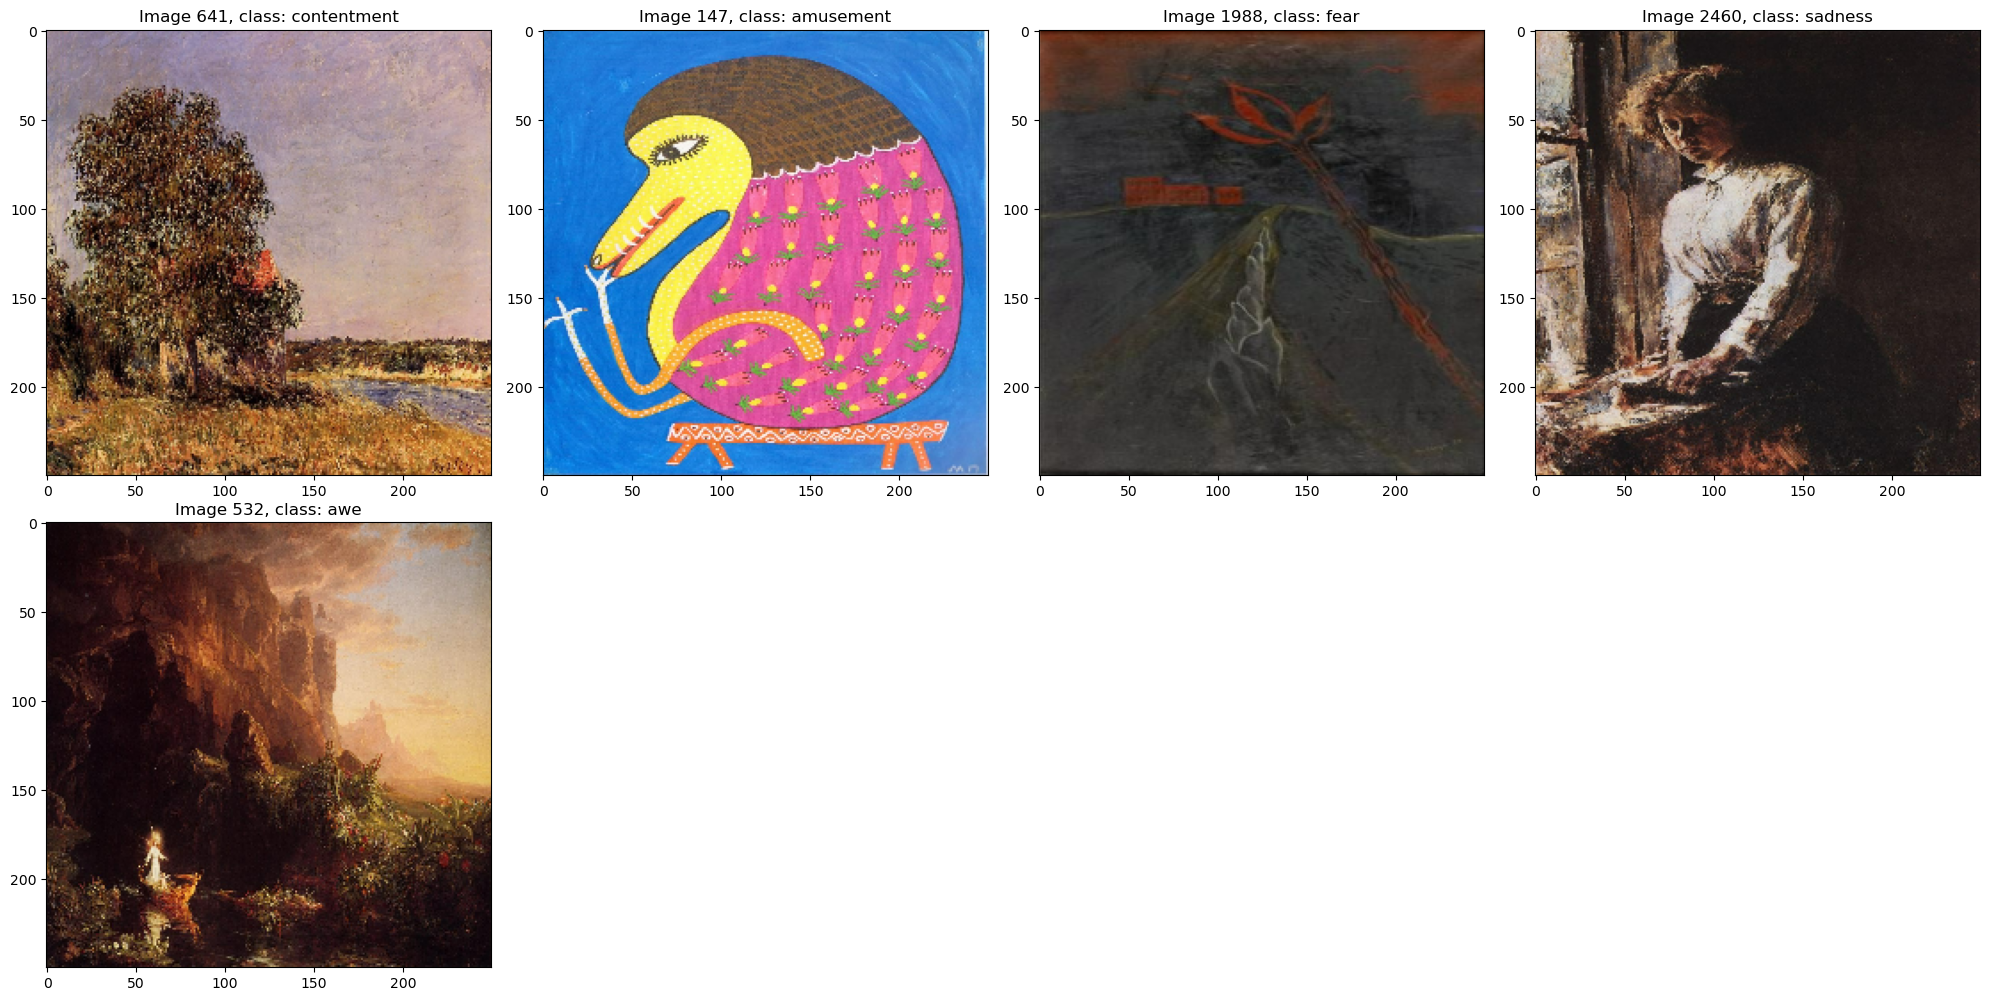

In [63]:
index_correct_image_contentment = rn.randint(0, len(contentment_correct_classified)-1)
index_correct_image_amusement = rn.randint(0, len(amusement_correct_classified)-1)
index_correct_image_fear = rn.randint(0, len(fear_correct_classified)-1)
index_correct_image_sadness = rn.randint(0, len(sadness_correct_classified)-1)
index_correct_image_awe = rn.randint(0, len(awe_correct_classified)-1)

plot_images_from_ds(test_ds_250,
            [contentment_correct_classified[index_correct_image_contentment][1], #lista di labes
             amusement_correct_classified[index_correct_image_amusement][1],
             fear_correct_classified[index_correct_image_fear][1],
             sadness_correct_classified[index_correct_image_sadness][1],
             awe_correct_classified[index_correct_image_awe][1]
             ],
             [contentment_correct_classified[index_correct_image_contentment][0], #lista di labes
             amusement_correct_classified[index_correct_image_amusement][0],
             fear_correct_classified[index_correct_image_fear][0],
             sadness_correct_classified[index_correct_image_sadness][0],
             awe_correct_classified[index_correct_image_awe][0]
             ])

In [64]:
images_extracted = extract_images_from_ds(test_ds_250,
            [contentment_correct_classified[index_correct_image_contentment][1], #lista di labes
             amusement_correct_classified[index_correct_image_amusement][1],
             fear_correct_classified[index_correct_image_fear][1],
             sadness_correct_classified[index_correct_image_sadness][1],
             awe_correct_classified[index_correct_image_awe][1]
             ],
             [contentment_correct_classified[index_correct_image_contentment][0], #lista di labes
             amusement_correct_classified[index_correct_image_amusement][0],
             fear_correct_classified[index_correct_image_fear][0],
             sadness_correct_classified[index_correct_image_sadness][0],
             awe_correct_classified[index_correct_image_awe][0]
             ])



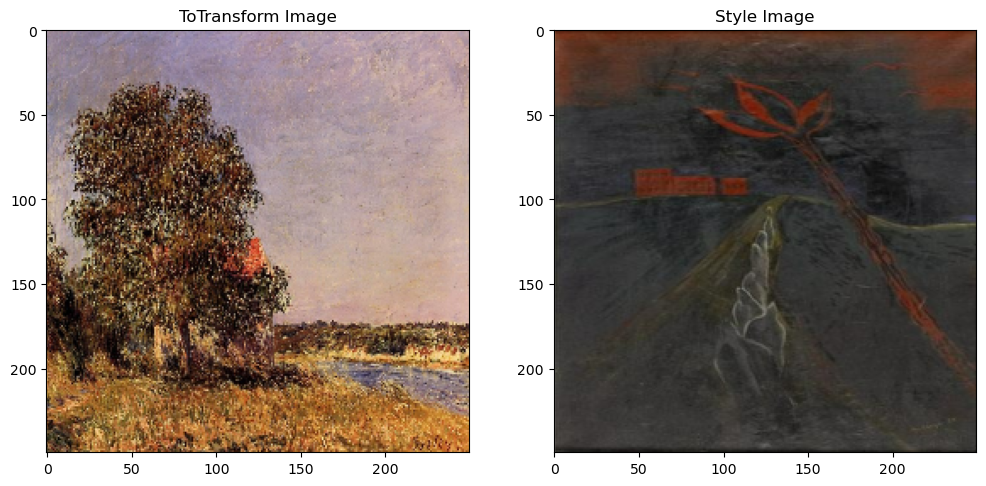

In [66]:
contentment_image = images_extracted[2]
amusement_image = images_extracted[0]
sadness_image = images_extracted[4]
fear_image = images_extracted[3]
awe_image = images_extracted[1]


content_image = tf.expand_dims(contentment_image, axis= 0)/255.0
style_image = tf.expand_dims(fear_image, axis= 0)/255.0

images_under_analysis = [fear_image, contentment_image]

plt.subplot(1, 2, 1)
imshow(content_image, 'ToTransform Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

## Extract style and content from images

In [67]:
content_image = tf.image.resize(content_image, [380,380])
style_image = tf.image.resize(style_image, [380,380])

In [68]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)


input_8
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


Choose intermediate layers from the network to represent the style and content of the image

In [69]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

With this style and content extractor, we can now implement the style transfer algorithm. Do this by calculating the mean square error for image's output relative to each target, then take the weighted sum of these losses.

In [72]:
extractor = StyleContentModel(style_layers, content_layers)

style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']



In [73]:
image = tf.Variable(content_image)


In [76]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [77]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

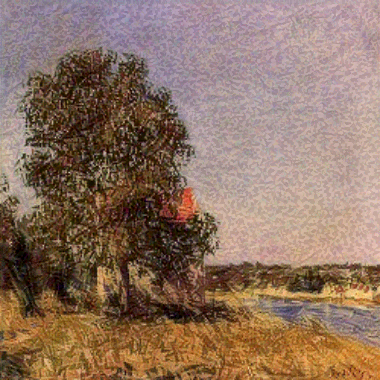

In [78]:
# only one step
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

Start the transformation phase

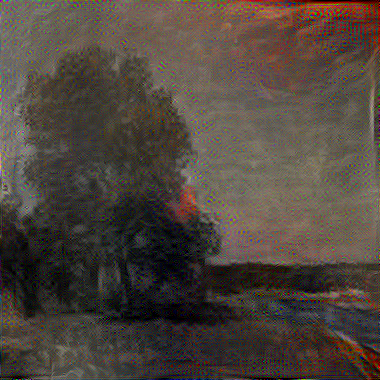

100%|██████████| 30/30 [03:09<00:00,  6.31s/it]

Train step: 3000


In [79]:
import time
start = time.time()

epochs = 30
steps_per_epoch = 100

step = 0
for n in tqdm(range(epochs)):
  for m in tqdm(range(steps_per_epoch)):
    step += 1
    train_step(image)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()

Per Binary e Multiclass sono uguali ---> Bisogna fare qualche modifica alle funzioni

In [80]:
path_model_from_scratch_1 = './majority_multiclass_models_sc/ex10_scratch_32_2x256_512_dp_regular_batchnorm_epoch_30_adam_1e-4.h5'

# path_pretrained_vgg16 = './majority_multiclass_models_sc/pretrained_vgg16_FINE_tuning_block4_conv1_512_dp_epoch_40_adam_1e-4.h5'
# path_pretrained_resnet50 = './majority_multiclass_models_sc/pretrained_RESNET_FINE_tuning_512_dp_epoch_40_adam_1e-4.h5'
# path_pretrained_mobilnet = './extra_majority_multiclass_models_sc/extra_pretrained_MOBILENETV2_no_tuning_512_dp_regularization_epoch_40_adam_1e-4.h5'
# path_pretrained_xception = './extra_majority_multiclass_models_sc/pretrained_extra_XCEPTION_no_tuning_512_dp_epoch_40_adam_1e-4.h5'

path_pretrained_vgg16 = './majority_multiclass_models_sc/pretrained_vgg16_no_tuning_experiment_4_epoch_40_adam_1e-4.h5'
path_pretrained_resnet50 = './majority_multiclass_models_sc/pretrained_RESNET_FINE_tuning_512_dp_epoch_40_adam_1e-4.h5'
path_pretrained_mobilnet = './extra_majority_multiclass_models_sc/extra_pretrained_MOBILENETV2_no_tuning_512_dp_regularization_epoch_40_adam_1e-4.h5'
path_pretrained_xception = './majority_multiclass_models_sc/pretrained_REMOVE_LAYER_block11sep_xception_no_tuning_dp_epoch_40_adam_1e-4.h5'

In [81]:
#model_from_scratch_0 = tf.keras.models.load_model(from_scratch_0)
model_from_scratch_1 = tf.keras.models.load_model(path_model_from_scratch_1)


model_pretrained_vgg16 = tf.keras.models.load_model(path_pretrained_vgg16)
model_pretrained_resnet50 = tf.keras.models.load_model(path_pretrained_resnet50)
model_pretrained_mobilnet = tf.keras.models.load_model(path_pretrained_mobilnet)
model_pretrained_xception = tf.keras.models.load_model(path_pretrained_xception)

models_trained = [model_from_scratch_1, model_pretrained_vgg16, 
                model_pretrained_resnet50, model_pretrained_mobilnet, model_pretrained_xception]

In [82]:
def return_list_of_prediction(models_trained, image):
    name_models = ['FROM_SCRATCH_1', 'VGG16', 'RESNET50', 'MOBILENETV2', 'XCEPTION']
    class_label = ['amusement', 'awe', 'contentment', 'fear', 'sadness']
    for i, model in enumerate(models_trained):
        if name_models[i] == 'MOBILENETV2':
            image = tf.image.resize(image, [240,240])
        else:
            image = tf.image.resize(image, [250,250])

        

        prediction = model(image)
        
        index_class = np.argmax(prediction, axis=1)[0]
        prediction = np.squeeze(prediction, axis=0)

    
        print(name_models[i]+":\n\t Amusement Percentage:"+str(prediction[0])+
                             ",\n\t Awe Percentage:"+str(prediction[1]) + 
                             ",\n\t Contentment Percentage:"+str(prediction[2])+
                             ",\n\t Fear Percentage:"+str(prediction[3])+
                             ",\n\t Sadness Percentage:"+str(prediction[4])+" -----> "+class_label[index_class])

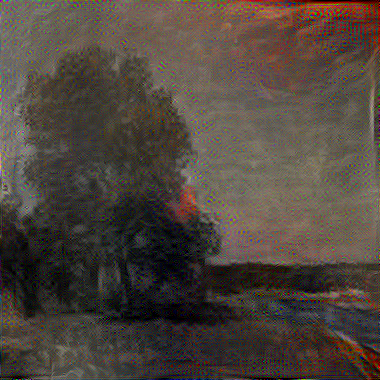

FROM_SCRATCH_1:
	 Amusement Percentage:0.016098637,
	 Awe Percentage:0.04760406,
	 Contentment Percentage:0.023385013,
	 Fear Percentage:0.7801508,
	 Sadness Percentage:0.1327616 -----> fear
VGG16:
	 Amusement Percentage:0.008348242,
	 Awe Percentage:0.20508647,
	 Contentment Percentage:0.49392006,
	 Fear Percentage:0.12998396,
	 Sadness Percentage:0.16266121 -----> contentment
RESNET50:
	 Amusement Percentage:0.007937538,
	 Awe Percentage:0.07735374,
	 Contentment Percentage:0.082966305,
	 Fear Percentage:0.784116,
	 Sadness Percentage:0.047626317 -----> fear
MOBILENETV2:
	 Amusement Percentage:0.036867265,
	 Awe Percentage:0.19209056,
	 Contentment Percentage:0.13385822,
	 Fear Percentage:0.24396443,
	 Sadness Percentage:0.39321953 -----> sadness
XCEPTION:
	 Amusement Percentage:0.0011130434,
	 Awe Percentage:0.17747767,
	 Contentment Percentage:0.03211382,
	 Fear Percentage:0.75079054,
	 Sadness Percentage:0.03850493 -----> fear


In [83]:
display.display(tensor_to_image(image))
image_tensor = tf.convert_to_tensor(image)
image_tensor = image_tensor*255
return_list_of_prediction(models_trained, image_tensor)

Now we will see the bahaviour of the networks on the transformed image.

### From_Scratch_1

In [85]:
model_from_scratch_1 = tf.keras.models.load_model(path_model_from_scratch_1)

model_from_scratch_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 250, 250, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 248, 248, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 124, 124, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 122, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 61, 61, 64)       0         
 2D)                                                         

#### HeatMap on Content and Style Image 

In [86]:
image_tensor = tf.image.resize(image_tensor, [250, 250]) # only for this model

images_array = []
pred_images = []
for img in images_under_analysis:
    print(img.shape)
    images_array.append(np.expand_dims(img, axis=0))
    pred_images.append(model_from_scratch_1.predict(np.expand_dims(img, axis=0)))

last_conv_layer_name = "conv2d_5" 
last_conv_layer = model_from_scratch_1.get_layer(last_conv_layer_name)
last_conv_layer_model = tf.keras.Model(model_from_scratch_1.inputs, last_conv_layer.output)

classifier_layer_names = [
    "global_average_pooling2d",
    "dense",
    "dense_1"
]
classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in classifier_layer_names:
    x = model_from_scratch_1.get_layer(layer_name)(x)
classifier_model = tf.keras.Model(classifier_input, x)

classifier_model.summary()

(250, 250, 3)
(250, 250, 3)
Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 12, 12, 512)]     0         
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dense_1 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 265,221
Trainable params: 265,221
Non-trainable params: 0
_________________________________________________________________


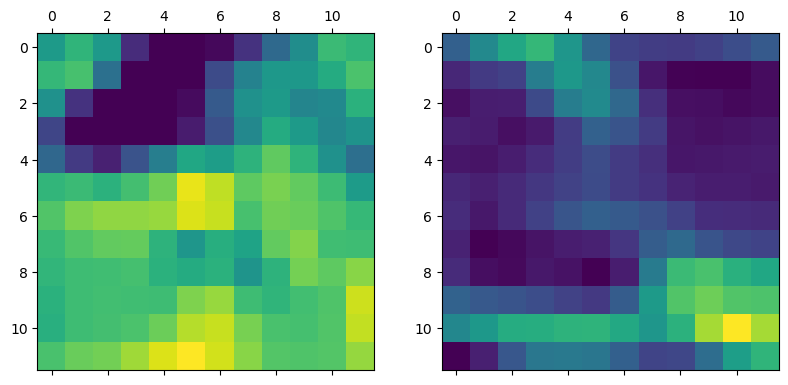

In [87]:
heatmaps = []
for image_array in images_array:
    heatmap = compute_grad(classifier_model, last_conv_layer_model, image_array)
    heatmaps.append(heatmap)
    #plt.matshow(heatmap)

plt.figure(figsize=(20, 20))
for i, heatmap in enumerate(heatmaps):
    plt.subplot(1, 4, i + 1)
    plt.matshow(heatmap, fignum=False)

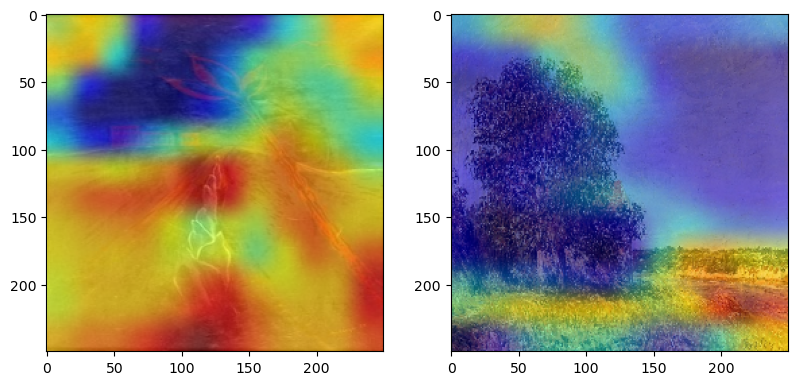

In [88]:
superimposed_images = superimposed_images_generation(heatmaps, images_under_analysis)

plt.figure(figsize= (20,20))
for i, superimposed_img in enumerate(superimposed_images):
    plt.subplot(1, 4, i + 1)
    plt.imshow(superimposed_img)

#### HeatMap on Transformed Image

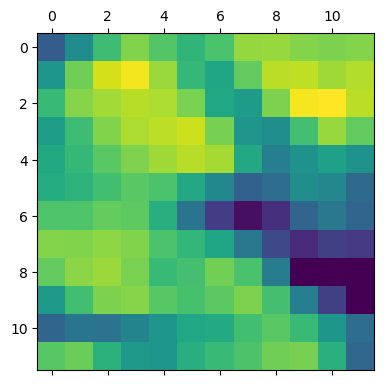

In [89]:
heatmap = compute_grad(classifier_model, last_conv_layer_model, image_tensor)
plt.figure(figsize=(20, 20))
plt.subplot(1, 4, i + 1)
plt.matshow(heatmap, fignum=False)

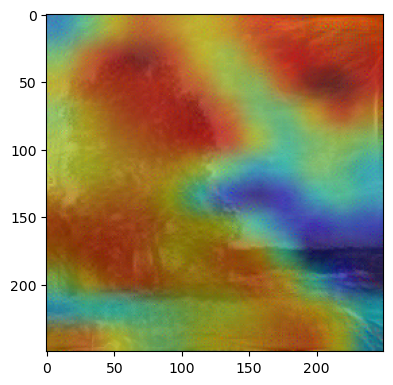

In [90]:
superimposed_img = superimposed_images_generation([heatmap], images_extracted=[np.squeeze(image_tensor, axis=0)])

plt.figure(figsize= (20,20))
for i, superimposed_img in enumerate(superimposed_img):
    plt.subplot(1, 4, i + 1)
    plt.imshow(superimposed_img)

### VGG16

In [91]:
model_vgg16 = tf.keras.models.load_model(path_pretrained_vgg16)

model_vgg16.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 tf.__operators__.getitem_2   (None, 250, 250, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_2 (TFOpLambd  (None, 250, 250, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_2   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                           

#### HeatMap on Content and Style Image 

In [92]:
vgg16 = model_vgg16.get_layer('vgg16')
image_tensor = tf.image.resize(image_tensor, [250,250])

images_array = []
pred_images = []
for img in images_under_analysis:
    img_prec = tf.keras.applications.vgg16.preprocess_input(img)
    images_array.append(np.expand_dims(img_prec, axis=0))
    pred_images.append(model_vgg16.predict(np.expand_dims(img, axis=0)))

last_conv_layer_name = "block5_conv3" 
last_conv_layer = vgg16.get_layer(last_conv_layer_name)
last_conv_layer_model = tf.keras.Model(vgg16.inputs, last_conv_layer.output)

classifier_layer_names = [
    "global_average_pooling2d_2",
    "dense_10",
    "dense_11",
    "dense_12",
    "dense_13",
    "dense_14"
]
classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in classifier_layer_names:
    x = model_vgg16.get_layer(layer_name)(x)
classifier_model = tf.keras.Model(classifier_input, x)

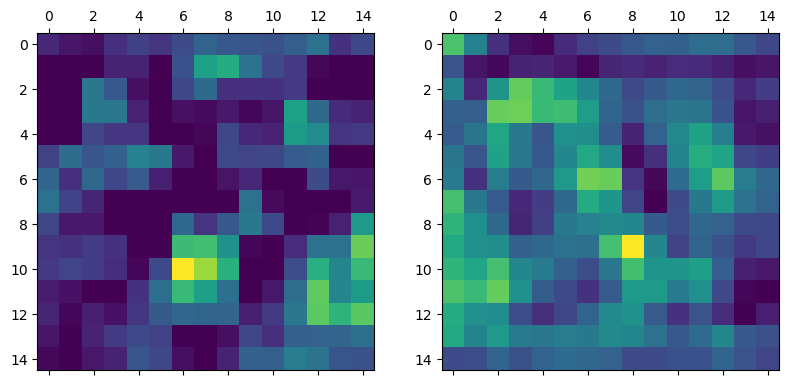

In [93]:
heatmaps = []
for image_array in images_array:
    heatmap = compute_grad(classifier_model, last_conv_layer_model, image_array)
    heatmaps.append(heatmap)
    #plt.matshow(heatmap)

plt.figure(figsize=(20, 20))
for i, heatmap in enumerate(heatmaps):
    plt.subplot(1, 4, i + 1)
    plt.matshow(heatmap, fignum=False)

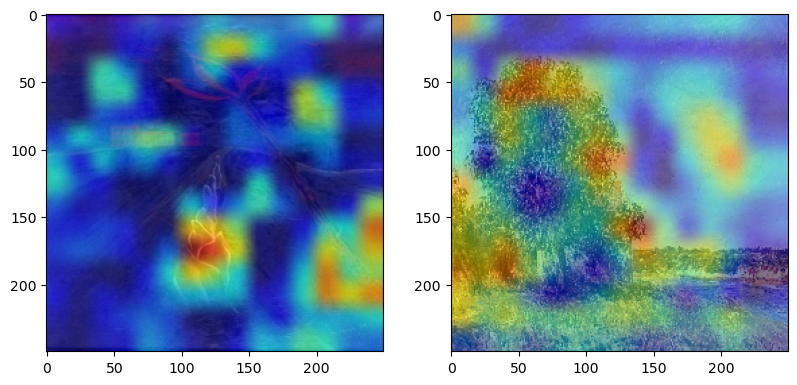

In [94]:
superimposed_images = superimposed_images_generation(heatmaps, images_under_analysis)

plt.figure(figsize= (20,20))
for i, superimposed_img in enumerate(superimposed_images):
    plt.subplot(1, 4, i + 1)
    plt.imshow(superimposed_img)

### HeatMap on Transformed Image

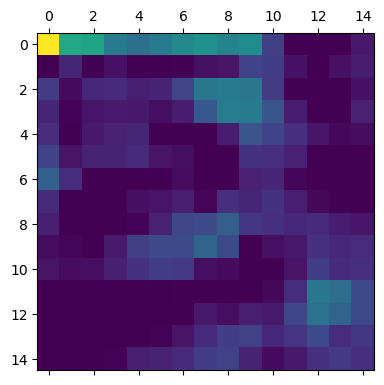

In [95]:
heatmap = compute_grad(classifier_model, last_conv_layer_model, image_tensor)
plt.figure(figsize=(20, 20))
plt.subplot(1, 4, i + 1)
plt.matshow(heatmap, fignum=False)

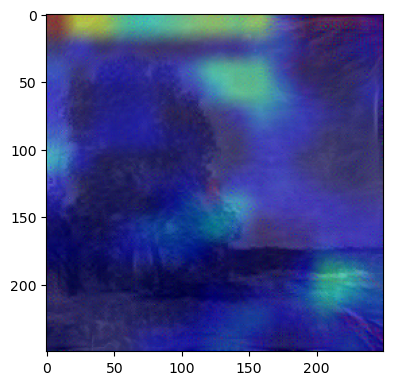

In [96]:
superimposed_img = superimposed_images_generation([heatmap], images_extracted=[np.squeeze(image_tensor, axis=0)])

plt.figure(figsize= (20,20))
for i, superimposed_img in enumerate(superimposed_img):
    plt.subplot(1, 4, i + 1)
    plt.imshow(superimposed_img)

### RESNET-50

In [97]:
model_resnet50 = tf.keras.models.load_model(path_pretrained_resnet50)

model_resnet50.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 tf.__operators__.getitem_1   (None, 250, 250, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 250, 250, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                           

#### HeatMap on Content and Style Image 

In [98]:
resnet50 = model_resnet50.get_layer('resnet50')
image_tensor = tf.image.resize(image_tensor, [250,250])
images_array = []
pred_images = []
for img in images_under_analysis:
    img_prec = tf.keras.applications.resnet.preprocess_input(img)
    images_array.append(np.expand_dims(img_prec, axis=0))
    pred_images.append(model_resnet50.predict(np.expand_dims(img, axis=0)))

last_conv_layer_name = "conv5_block3_out" # output shape (x, 7, 7, 128)
last_conv_layer = resnet50.get_layer(last_conv_layer_name)
last_conv_layer_model = tf.keras.Model(resnet50.inputs, last_conv_layer.output)

In [99]:
classifier_layer_names = [
    "global_average_pooling2d_1",
    "dense_6",
    "dense_7",
    "dense_8"
]
classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in classifier_layer_names:
    x = model_resnet50.get_layer(layer_name)(x)
classifier_model = tf.keras.Model(classifier_input, x)

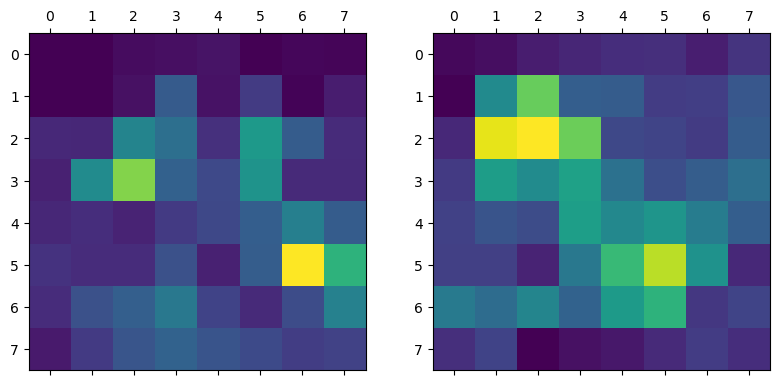

In [100]:
heatmaps = []
for image_array in images_array:
    heatmap = compute_grad(classifier_model, last_conv_layer_model, image_array)
    heatmaps.append(heatmap)
    #plt.matshow(heatmap)

plt.figure(figsize=(20, 20))
for i, heatmap in enumerate(heatmaps):
    plt.subplot(1, 4, i + 1)
    plt.matshow(heatmap, fignum=False)

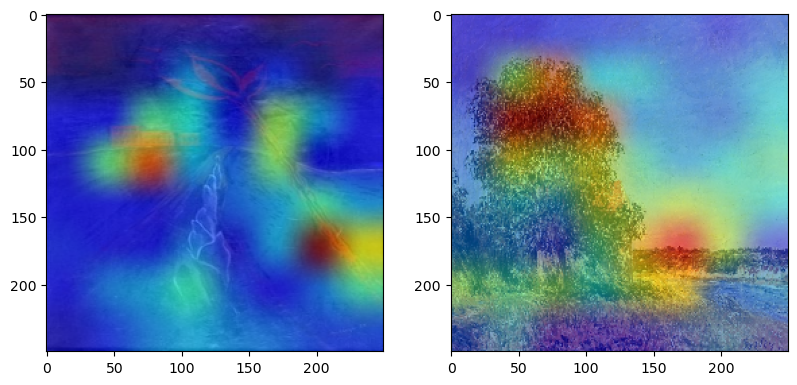

In [101]:
superimposed_images = superimposed_images_generation(heatmaps, images_under_analysis)

plt.figure(figsize= (20,20))
for i, superimposed_img in enumerate(superimposed_images):
    plt.subplot(1, 4, i + 1)
    plt.imshow(superimposed_img)

#### HeatMap on Transformed Image

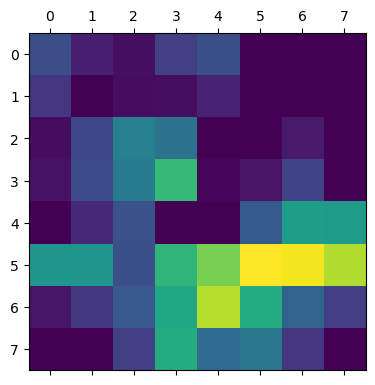

In [102]:
heatmap = compute_grad(classifier_model, last_conv_layer_model, image_tensor)
plt.figure(figsize=(20, 20))
plt.subplot(1, 4, i + 1)
plt.matshow(heatmap, fignum=False)

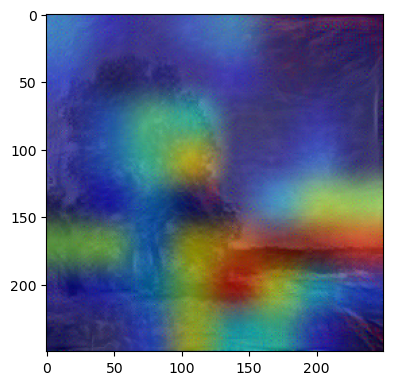

In [103]:
superimposed_img = superimposed_images_generation([heatmap], images_extracted=[np.squeeze(image_tensor, axis=0)])

plt.figure(figsize= (20,20))
for i, superimposed_img in enumerate(superimposed_img):
    plt.subplot(1, 4, i + 1)
    plt.imshow(superimposed_img)

### MOBILENET

In [104]:
model_mobilnet = tf.keras.models.load_model(path_pretrained_mobilnet)

model_mobilnet.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 240, 240, 3)]     0         
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 240, 240, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_3 (TFOpLam  (None, 240, 240, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_7   (None, 1280)             0         
 (GlobalAveragePooling2D)                                  

#### HeatMap on Content and Style Image 

In [105]:
mobilnet = model_mobilnet.get_layer('mobilenetv2_1.00_224')
image_tensor = tf.image.resize(image_tensor, [240,240])

images_array = []
pred_images = []
for img in images_under_analysis:
    img = tf.image.resize(img, [240,240])
    img_pre = tf.keras.applications.mobilenet_v2.preprocess_input(img)
    images_array.append(np.expand_dims(img_pre, axis=0))
    pred_images.append(model_mobilnet.predict(np.expand_dims(img, axis=0)))

last_conv_layer_name = "Conv_1" 
last_conv_layer = mobilnet.get_layer(last_conv_layer_name)
last_conv_layer_model = tf.keras.Model(mobilnet.inputs, last_conv_layer.output)

classifier_layer_names = [
    "global_average_pooling2d_7",
    "dense_15",
    "dense_16"
]
classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in classifier_layer_names:
    x = model_mobilnet.get_layer(layer_name)(x)
classifier_model = tf.keras.Model(classifier_input, x)

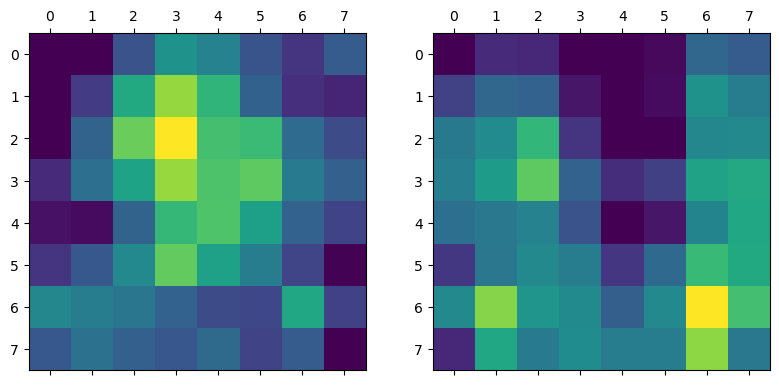

In [106]:
heatmaps = []
for image_array in images_array:
    heatmap = compute_grad(classifier_model, last_conv_layer_model, image_array)
    heatmaps.append(heatmap)
    #plt.matshow(heatmap)

plt.figure(figsize=(20, 20))
for i, heatmap in enumerate(heatmaps):
    plt.subplot(1, 4, i + 1)
    plt.matshow(heatmap, fignum=False)

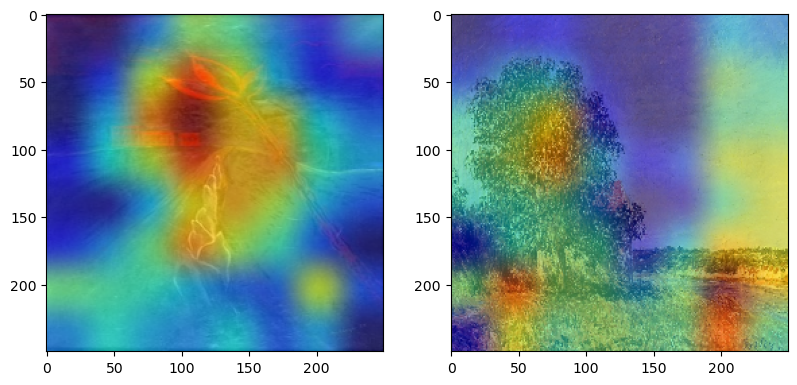

In [107]:
superimposed_images = superimposed_images_generation(heatmaps, images_under_analysis)

plt.figure(figsize= (20,20))
for i, superimposed_img in enumerate(superimposed_images):
    plt.subplot(1, 4, i + 1)
    plt.imshow(superimposed_img)

#### HeatMap on Transformed Image

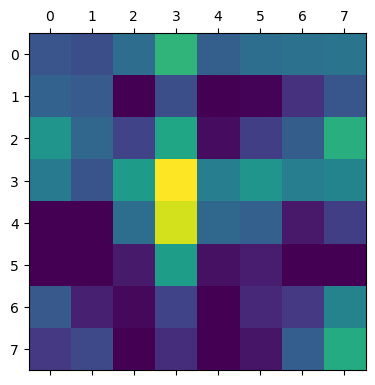

In [108]:
heatmap = compute_grad(classifier_model, last_conv_layer_model, image_tensor)
plt.figure(figsize=(20, 20))
plt.subplot(1, 4, i + 1)
plt.matshow(heatmap, fignum=False)

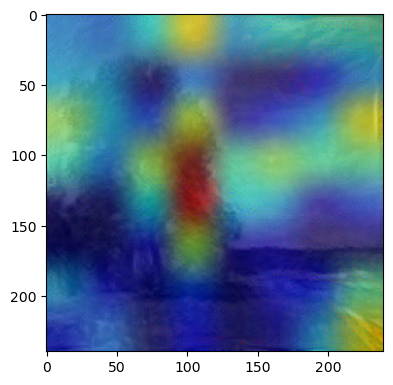

In [109]:
superimposed_img = superimposed_images_generation([heatmap], images_extracted=[np.squeeze(image_tensor, axis=0)])

plt.figure(figsize= (20,20))
for i, superimposed_img in enumerate(superimposed_img):
    plt.subplot(1, 4, i + 1)
    plt.imshow(superimposed_img)

### XCEPTION

In [110]:
model_xception = tf.keras.models.load_model(path_pretrained_xception)

model_xception.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 250, 250, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 250, 250, 3)      0         
 bda)                                                            
                                                                 
 xception_cut (Functional)   (None, 16, 16, 728)       10823688  
                                                                 
 global_average_pooling2d_1   (None, 728)              0         
 (GlobalAveragePooling2D)                                        
                                                           

#### HeatMap on Content and Style Image 

In [111]:
xception = model_xception.get_layer('xception_cut')
image_tensor = tf.image.resize(image_tensor, [250,250])

images_array = []
pred_images = []
for img in images_under_analysis:
    img_pre = tf.keras.applications.xception.preprocess_input(img)
    images_array.append(np.expand_dims(img_pre, axis=0))
    pred_images.append(model_xception.predict(np.expand_dims(img, axis=0)))

last_conv_layer_name = "block11_sepconv1_act" 
last_conv_layer = xception.get_layer(last_conv_layer_name)
last_conv_layer_model = tf.keras.Model(xception.inputs, last_conv_layer.output)

classifier_layer_names = [
    "global_average_pooling2d_1",
    "dense_5",
    "dense_6"
]
classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in classifier_layer_names:
    x = model_xception.get_layer(layer_name)(x)
classifier_model = tf.keras.Model(classifier_input, x)

(1, 250, 250, 3)
(1, 250, 250, 3)


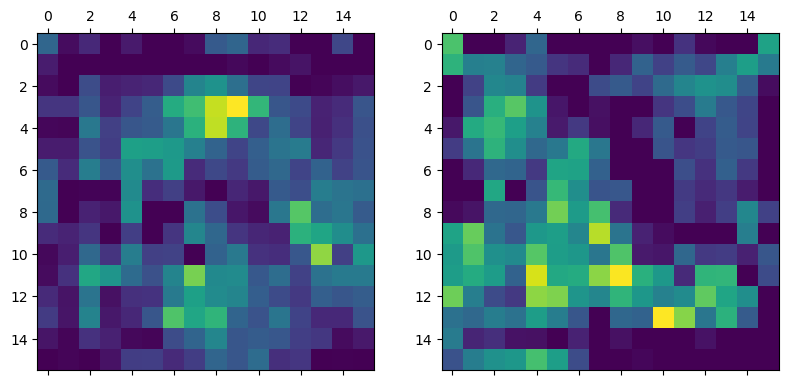

In [112]:
heatmaps = []
for image_array in images_array:
    print(image_array.shape)
    heatmap = compute_grad(classifier_model, last_conv_layer_model, image_array)
    heatmaps.append(heatmap)
    #plt.matshow(heatmap)

plt.figure(figsize=(20, 20))
for i, heatmap in enumerate(heatmaps):
    plt.subplot(1, 4, i + 1)
    plt.matshow(heatmap, fignum=False)

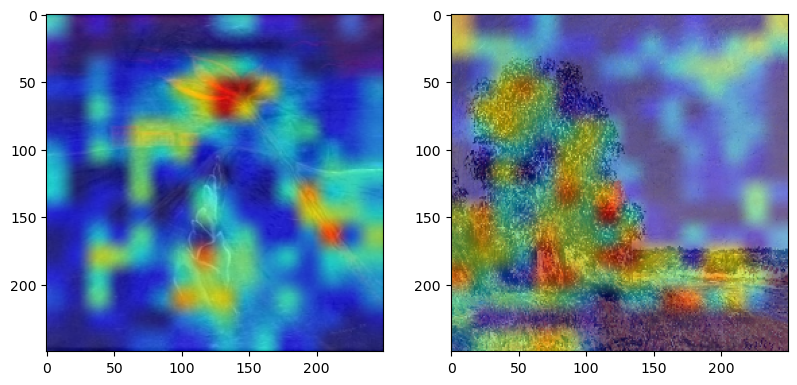

In [113]:
superimposed_images = superimposed_images_generation(heatmaps, images_under_analysis)

plt.figure(figsize= (20,20))
for i, superimposed_img in enumerate(superimposed_images):
    plt.subplot(1, 4, i + 1)
    plt.imshow(superimposed_img)

#### HeatMap on Transformed Image

(1, 250, 250, 3)


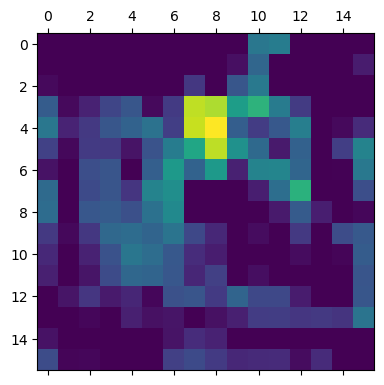

In [114]:
print(image_tensor.shape)
heatmap = compute_grad(classifier_model, last_conv_layer_model, image_tensor)
plt.figure(figsize=(20, 20))
plt.subplot(1, 4, i + 1)
plt.matshow(heatmap, fignum=False)

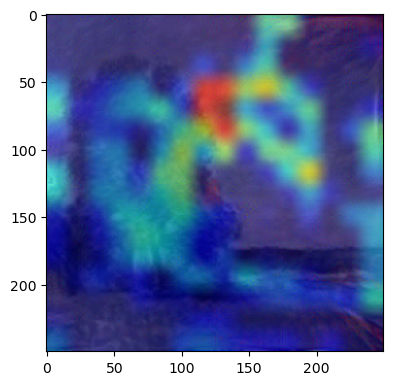

In [115]:
superimposed_img = superimposed_images_generation([heatmap], images_extracted=[np.squeeze(image_tensor, axis=0)])

plt.figure(figsize= (20,20))
for i, superimposed_img in enumerate(superimposed_img):
    plt.subplot(1, 4, i + 1)
    plt.imshow(superimposed_img)